1. Autoencoder

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,LSTM,Conv1D,GlobalMaxPooling1D
from keras.models import Model
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.utils import np_utils
from keras.applications import VGG16
import cv2
from urllib.request import urlopen
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 9s 148us/step - loss: 0.3803 - val_loss: 0.3405
Epoch 2/15
60000/60000 [==============================] - 7s 114us/step - loss: 0.3254 - val_loss: 0.3164
Epoch 3/15
60000/60000 [==============================] - 7s 114us/step - loss: 0.3130 - val_loss: 0.3083
Epoch 4/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.3067 - val_loss: 0.3060
Epoch 5/15
60000/60000 [==============================] - 7s 110us/step - loss: 0.3029 - val_loss: 0.3046
Epoch 6/15
60000/60000 [==============================] - 7s 110us/step - loss: 0.3002 - val_loss: 0.3044
Epoch 7/15
60000/60000 [==============================] - 7s 109us/step - loss: 0.2983 - val_loss: 0.2981
Epoch 8/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.2968 - val_loss: 0.2995
Epoch 9/15
60000/60000 [==============================] - 6s 108us/step - loss: 0.2954 - val_loss: 0.2

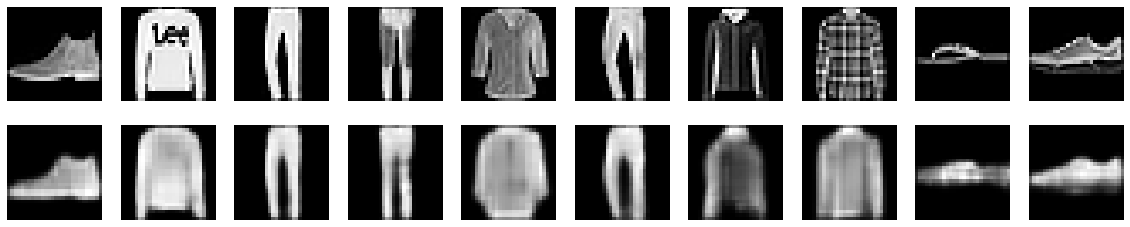

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2. Image Classification

2.1 Deep CNN

In [0]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [0]:
model = Sequential()
#add the Conv2D layer with kernel size 3*3 and relu activatioin function with stride 1
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
#add the remaining layers with 2 by 2 Maxpooling layer and 0.25 Dropout rate
model.add(Conv2D(64, (3, 3), activation='relu'))
#using 2*2 size for max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#the fully connected layer with 128 Dense nodes, and 0.5 Dropout rate
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#Class layer
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
history = model.fit(x=x_train,y=y_train, epochs=10,batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.4790 - acc: 0.8308
Epoch 2/10
60000/60000 [==============================] - 21s 348us/step - loss: 0.3196 - acc: 0.8845
Epoch 3/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.2728 - acc: 0.8997
Epoch 4/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.2428 - acc: 0.9107
Epoch 5/10
60000/60000 [==============================] - 21s 352us/step - loss: 0.2198 - acc: 0.9187
Epoch 6/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.2013 - acc: 0.9248
Epoch 7/10
60000/60000 [==============================] - 21s 354us/step - loss: 0.1881 - acc: 0.9294
Epoch 8/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.1748 - acc: 0.9356
Epoch 9/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.1631 - acc: 0.9388
Epoch 10/10
60000/60000 [==============================] - 21s 351us/step - loss: 

In [0]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9296


In [0]:
score_1 = model.evaluate(x_train, y_train, verbose=0)
# Print training accuracy
print('\n', 'Training accuracy:', score_1[1])


 Training accuracy: 0.9699166666666666


2.2 Transfer learning

In [0]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
x_train_2 = np.dstack([x_train] * 3)
x_test_2 = np.dstack([x_test] * 3)

x_train_2 = x_train_2.reshape(-1, 28, 28, 3)
x_test_2 = x_test_2.reshape (-1, 28, 28, 3)

x_train_2 = np.asarray([cv2.resize(i, (48,48)) for i in x_train_2])
x_test_2 = np.asarray([cv2.resize(i, (48,48)) for i in x_test_2])


x_train_2.shape, x_test_2.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [0]:
model_2 = Sequential()
model_2.add(base_model)
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='softmax'))

In [0]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 14,781,642
Trainable params: 14,781,642
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [0]:
history_2 = model_2.fit(x_train_2,y_train, 
                    epochs=10, 
                    batch_size=128,
                    verbose = 1,
                    validation_data = (x_test_2, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 118s 2ms/step - loss: 1.5164 - acc: 0.3947 - val_loss: 0.9464 - val_acc: 0.6403
Epoch 2/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.6266 - acc: 0.7658 - val_loss: 0.5762 - val_acc: 0.7938
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.4477 - acc: 0.8445 - val_loss: 0.3840 - val_acc: 0.8631
Epoch 4/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.3814 - acc: 0.8668 - val_loss: 0.3621 - val_acc: 0.8741
Epoch 5/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.3478 - acc: 0.8784 - val_loss: 0.3692 - val_acc: 0.8621
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.3189 - acc: 0.8877 - val_loss: 0.3375 - val_acc: 0.8766
Epoch 7/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.2805 - acc: 0.9014 - val_loss: 0.3116 - 

In [0]:
# Evaluate the model on test set
score_2 = model_2.evaluate(x_test_2, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score_2[1])


 Test accuracy: 0.8951


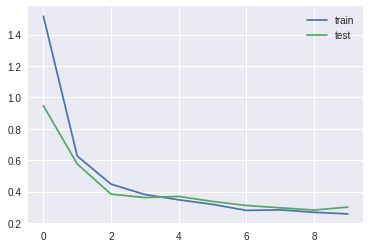

In [0]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')

3. Text Classification

3.1 RNN

In [0]:
benign_urls = urlopen('https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt').read().decode("utf-8").split("\n")
malicious_urls = urlopen('https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt').read().decode("utf-8").split("\n")

In [0]:
benign = pd.DataFrame(benign_urls)
malicious = pd.DataFrame(malicious_urls)

In [0]:
benign.columns = ['urls']
malicious.columns = ['urls']

benign['ben_mal'] = 0
malicious['ben_mal'] = 1
#benign.head()
#malicious.head()

In [0]:
urls = pd.concat([benign, malicious])
urls.head()

,urls,ben_mal
0,# GOOGLE,0
1,.0.blogger.gmodules.com,0
2,.0.client-channel.google.com,0
3,.0.docs.google.com,0
4,.0.drive.google.com,0


In [0]:
tokenizer = Tokenizer(filters=None, char_level=True)
tokenizer.fit_on_texts(urls['urls'])
train_x = tokenizer.texts_to_sequences(urls['urls'])
train_y = urls['ben_mal']
train_x = sequence.pad_sequences(train_x)

In [0]:
max_length = max(len(tk)for tk in train_x)

In [0]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(train_x, train_y, test_size=0.35, random_state=15)

In [0]:
rnn = Sequential()
rnn.add(Embedding(5000, 32, input_length=max_length))
rnn.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(1, activation="sigmoid"))

In [0]:
rnn.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [0]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 86, 32)            160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 161,731
Trainable params: 161,731
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn_history = rnn.fit(X_train_3, y_train_3, batch_size =32, epochs = 5,  verbose = 1)

Epoch 1/5
43780/43780 [==============================] - 387s 9ms/step - loss: 0.0930 - acc: 0.9810
Epoch 2/5
43780/43780 [==============================] - 383s 9ms/step - loss: 0.0362 - acc: 0.9834
Epoch 3/5
43780/43780 [==============================] - 388s 9ms/step - loss: 0.0278 - acc: 0.9858
Epoch 4/5
43780/43780 [==============================] - 389s 9ms/step - loss: 0.0253 - acc: 0.9874
Epoch 5/5
43780/43780 [==============================] - 390s 9ms/step - loss: 0.0239 - acc: 0.9879


In [0]:
# Evaluate the model on test set
score_3 = rnn.evaluate(X_test_3, y_test_3, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score_3[1])


 Test accuracy: 0.9889284805293967


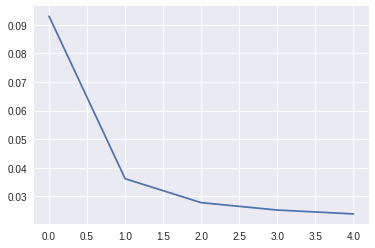

In [0]:
plt.plot(rnn_history.history['loss'])

3.2 CNN

In [0]:
cnn = Sequential()
cnn.add(Embedding(5000, 64, input_length=max_length))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(32, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dropout(0.2))
cnn.add(Dense(1, activation='sigmoid'))

In [0]:
cnn.compile(loss = 'binary_crossentropy', optimizer='rmsprop',metrics = ['acc'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 86, 64)            320000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 86, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 82, 32)            10272     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 330,305
Trainable params: 330,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
cnn_history = cnn.fit(X_train_3, y_train_3, batch_size =32, epochs = 5,  verbose = 1)

Epoch 1/5
43780/43780 [==============================] - 10s 238us/step - loss: 0.0267 - acc: 0.9889
Epoch 2/5
43780/43780 [==============================] - 10s 231us/step - loss: 0.0256 - acc: 0.9897
Epoch 3/5
43780/43780 [==============================] - 10s 228us/step - loss: 0.0257 - acc: 0.9902
Epoch 4/5
43780/43780 [==============================] - 10s 231us/step - loss: 0.0248 - acc: 0.9906
Epoch 5/5
43780/43780 [==============================] - 10s 235us/step - loss: 0.0244 - acc: 0.9908


In [0]:
# Evaluate the model on test set
score_4 = cnn.evaluate(X_test_3, y_test_3, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score_4[1])


 Test accuracy: 0.9889284805293967


3.3

In [0]:
y_test_3_preds_rnn = rnn.predict(X_test_3).ravel()
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(y_test_3, y_test_3_preds_rnn)
rnn_auc = auc(rnn_fpr, rnn_tpr)

y_test_3_preds_cnn = cnn.predict(X_test_3).ravel()
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(y_test_3, y_test_3_preds_cnn)
cnn_auc = auc(cnn_fpr, cnn_tpr)

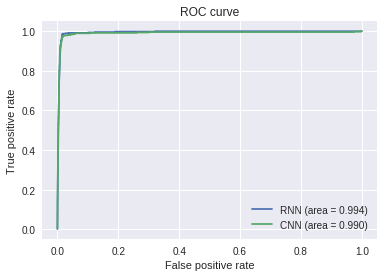

In [0]:
plt.figure()
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(cnn_fpr, cnn_tpr, label='CNN (area = {:.3f})'.format(cnn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

From the roc curve, we can see that the two neural networks have the similar performance